In [37]:
from astropy.io import fits as pyfits, ascii as asc
from astropy.table import Table
from create_ordered_AP_arrays import create_ordered_AP_arrays
import numpy as np, matplotlib.pyplot as plt
import plotting.general_plotting as general_plotting

from analysis.cardelli import *
from scipy import stats
from scipy.interpolate import interp1d
from astropy.cosmology import FlatLambdaCDM
cosmo = FlatLambdaCDM(H0 = 70 * u.km / u.s / u.Mpc, Om0=0.3)


FULL_PATH = '/Users/kaitlynshin/GoogleDrive/NASA_Summer2015/'

## EBV_corrections.py

In [52]:
def apply_filt_corrs(no_spectra, yes_spectra, ff, zspec0, FLUX_filt_corr):
    '''
    Applies the filter-based correction.

    Accepts only no/yes_spectra sources with filter matches (based on NAME0).

    For the sources with no_spectra, a log correction factor of 1.28 was added.
    For the ones with a yes_spectra, the relevant filter response .dat file
    was read in to try and find what kind of flux a source with that zspec
    would have in the filter response; a log correction factor of 1 over
    that ratio was then added, with the filter-corrected flux returned.
    '''
    print ff, len(no_spectra)+len(yes_spectra)
    # reading data
    response = asc.read(FULL_PATH+'Filters/'+ff+'response.dat',guess=False,
                    Reader=asc.NoHeader)
    xresponse = np.array(response['col1'])
    xresponse = (xresponse/6563.0)-1                    
    yresponse = np.array(response['col2'])
    yresponse = (yresponse/max(yresponse)) #normalize to 1

    FLUX_filt_corr[no_spectra] += np.log10(1.28)

    good_z = zspec0[yes_spectra]
    for ii in range(len(yes_spectra)):            
        temp = np.array([x for x in range(len(xresponse)-1)
                         if good_z[ii] > xresponse[x]
                         and good_z[ii] < xresponse[x+1]])

        if len(temp) == 0:
            FLUX_filt_corr[yes_spectra[ii]] += np.log10(1.28)
        elif len(temp) > 0:
            avg_y_response = np.mean((yresponse[temp], yresponse[temp+1]))
            FLUX_filt_corr[yes_spectra[ii]] += np.log10(1/avg_y_response)
        #endif
    #endfor
    return FLUX_filt_corr


def apply_filt_corrs2(ff, filt_corrs, zspec0, bad_z, good_z):
    filt_corrs[bad_z] = np.log10(1.28)

    tab0 = asc.read(FULL_PATH+'Filters/'+ff+'response.dat',guess=False,
        Reader=asc.NoHeader)
    z_filt = tab0['col1'].data/6562.8 - 1
    print min(z_filt), max(z_filt)
    print min(zspec0[good_z]), max(zspec0[good_z])

#     if ff=='NB921':
#         print z_filt
#         print zspec0[good_z]
    
    f = interp1d(z_filt, tab0['col2'])
    filt_corrs[good_z] = np.log10(1.0/(f(zspec0[good_z])/max(tab0['col2'])))

    return filt_corrs


def get_nii_corr(allcolsdata, ratio0, ratio1, coverage):
    '''
    Finds the 'good' indexes, where the sources have either full coverage
    or a limit. Those sources are then added to two different arrays,
    with the respective ratios added to an array (NII_corr) that is returned
    at the end.

    The array good_index1 was also returned to show which sources in the
    returned array had full coverage.
    '''
    good_index1 = np.array([])
    good_index2 = np.array([])
    for x in range(len(ratio0)):
        try:
            num0 = float(ratio0[x])
            num1 = float(ratio1[x])
            if num0 != -1. and num0 != 0. and num1 != -1.:
                if coverage[x] == 0:
                    good_index1 = np.append(good_index1, x)
                elif coverage[x] == 1:
                    good_index2 = np.append(good_index2, x)
        except ValueError:
            pass
    #endfor
    good_index1 = np.int_(good_index1)
    good_index2 = np.int_(good_index2)

    NII_corr = np.zeros(len(allcolsdata))
    NII_corr[good_index1] = np.float_(ratio0[good_index1])
    NII_corr[good_index2] = np.float_(ratio0[good_index2])
    return NII_corr, good_index1


def get_nii_line_corr(good_index1, allcolsdata, stlr_mass, ratio0):
    '''
    Creates the line of best fit that is also plotted in
    NII_Ha_MMT_scatter.pdf. Using that line of best-fit, depending on the
    stellar mass of the point, an array of correction factors is returned.
    '''
    nii_corr1 = np.zeros(len(allcolsdata))
    good_stlr = stlr_mass[good_index1]
    good_ratio = np.log10(np.float_(ratio0[good_index1]))
    slope, intercept, r_value, p_value, std_err = stats.linregress(good_stlr,
                                                                   good_ratio)
    for (x, ii) in zip(stlr_mass, range(len(nii_corr1))):
        if x >= max(good_stlr):
            y = slope*max(good_stlr) + intercept
        elif x <= min(good_stlr):
            y = slope*min(good_stlr) + intercept
        else:
            stlr = np.sort(good_stlr)
            match_index = np.array([s for s in range(len(stlr)-1)
                                    if x >= stlr[s] and x <= stlr[s+1]])
            stlr_val=np.mean((stlr[match_index], stlr[match_index+1]))
            y = slope*stlr_val + intercept
        #endif
        nii_corr1[ii] = y
    #endfor
    return 10**nii_corr1


def consolidate_ns_ys(orig_fluxes, no_spectra, yes_spectra, data_ns, data_ys, datatype='num'):
    '''
    consolidates no_spectra and yes_spectra data into a single data_array
    of shape orig_fluxes
    '''
    consod = np.zeros(len(orig_fluxes))
    if datatype == 'str':
        consod = np.array(['']*len(orig_fluxes), dtype='|S10')

    consod[no_spectra] = data_ns
    consod[yes_spectra] = data_ys

    return consod


def get_bins(masslist_MMT, masslist_Keck, massZlist_MMT, massZlist_Keck):
    '''
    Helper function for main. Flattens ndarrays of bins into a bins array

    Doesn't include the max_mass as an upper bound to the mass bins so that
    sources that have m > m_max_bin will automatically fall into the highest
    bin.
    Ex:
      >>> x = np.array([5.81, 6.78, 7.12, 7.94, 9.31])
      >>> bins = np.array([6.2, 7.53, 9.31]) 
      >>> np.digitize(x, bins, right=True)
      array([0, 1, 1, 2, 2]) # instead of array([0, 1, 1, 2, 3])
    '''
    massbins_MMT = np.append(masslist_MMT[:,0], masslist_MMT[-1,-1])
    massbins_Keck = np.append(masslist_Keck[:,0], masslist_Keck[-1,-1])
    massZbins_MMT = np.append(massZlist_MMT[:,0], massZlist_MMT[-1,-1])
    massZbins_Keck = np.append(massZlist_Keck[:,0], massZlist_Keck[-1,-1])

    return massbins_MMT, massbins_Keck, massZbins_MMT, massZbins_Keck


def fix_masses_out_of_range(masses_MMT_ii, masses_Keck_ii, masstype):
    '''
    Fixes masses that were not put into bins because they were too low.
    Reassigns them to the lowest mass bin. 

    Does this for both stlrmass bins and stlrmassZ bins.
    '''
    if masstype=='stlrmass':
        masses_MMT_ii = np.array([1 if x==0 else x for x in masses_MMT_ii])
        masses_Keck_ii = np.array([1 if x==0 else x for x in masses_Keck_ii])
    else: #=='stlrmassZ'
        masses_MMT_ii = np.array(['1'+x[1:] if x[0]=='0' else x for x in masses_MMT_ii])
        masses_Keck_ii = np.array(['1'+x[1:] if x[0]=='0' else x for x in masses_Keck_ii])

    return masses_MMT_ii, masses_Keck_ii


def bins_table_no_spectra(indexes, NAME0, AP, stlr_mass, massbins_MMT, massbins_Keck, 
    massZbins_MMT, massZbins_Keck, massZlist_filts_MMT, massZlist_filts_Keck):
    '''
    Creates and returns a table of bins as such:

    NAME             stlrmass filter stlrmassbin_MMT stlrmassbin_Keck stlrmassZbin_MMT stlrmassZbin_Keck
    ---------------- -------- ------ --------------- ---------------- ---------------- -----------------
    Ha-NB973_178201  8.4      NB973  4               3                2-NB973          2-NB973

    WARNINGS: 
    - dual Ha-NB704/Ha-NB711 sources are being treated as Ha-NB704 sources for now, but
      we may have to use photometry to better determine which EBV values to use
    - Ha-NB704+OII-NB973 sources are being treated as Ha-NB704 sources for now, but 
      they may be excluded as they may be something else given the NB973 excess
    '''
    names = NAME0[indexes]
    masses = stlr_mass[indexes]

    # get redshift bins
    filts = np.array([x[x.find('Ha-')+3:x.find('Ha-')+8] for x in names])
    
    # this ensures that NB704+NB921 dual emitters will be placed in Ha-NB921 bins
    #  since these sources are likely OIII-NB704 and Ha-NB921
    dual_iis = [x for x in range(len(names)) if 'Ha-NB704' in names[x] and 'Ha-NB921' in names[x]]
    filts[dual_iis] = 'NB921'
    
    # this ensures that the NB816+NB921 dual emitter will be placed in the NB921 bin
    #  we decided this based on visual inspection of the photometry
    dual_ii2 = [x for x in range(len(names)) if 'Ha-NB816' in names[x] and 'Ha-NB921' in names[x]]
    filts[dual_ii2] = 'NB921'

    # get stlrmass bins
    masses_MMT_ii = np.digitize(masses, massbins_MMT, right=True)
    masses_Keck_ii = np.digitize(masses, massbins_Keck, right=True)
    masses_MMT, masses_Keck = fix_masses_out_of_range(masses_MMT_ii, masses_Keck_ii, 'stlrmass')
    
    # get stlrmassZ bins
    ii0 = 0
    ii1 = 0
    massZs_MMT = np.array(['UNFILLED']*len(indexes))
    massZs_Keck = np.array(['UNFILLED']*len(indexes))
    for ff in ['NB704','NB711','NB816','NB921','NB973']:
        jj = len(np.where(ff==massZlist_filts_MMT)[0])        
        
        good_filt_iis = np.array([x for x in range(len(filts)) if filts[x]==ff])
        
        if ff=='NB973':
            jj += 1
        
        mass_MMT_iis  = np.digitize(masses[good_filt_iis], massZbins_MMT[ii0:ii0+jj], right=True)
        massZ_MMT_iis = np.array([str(x)+'-'+ff for x in mass_MMT_iis])
        massZs_MMT[good_filt_iis] = massZ_MMT_iis
        
        ii0+=jj
        if 'NB9' in ff:
            kk = len(np.where(ff==massZlist_filts_Keck)[0])

            if ff=='NB973':
                kk += 1
                
            mass_Keck_iis  = np.digitize(masses[good_filt_iis], massZbins_Keck[ii1:ii1+kk], right=True)
            massZ_Keck_iis = np.array([str(x)+'-'+ff for x in mass_Keck_iis])
            massZs_Keck[good_filt_iis] = massZ_Keck_iis
            
            ii1+=kk
        else:
            massZs_Keck[good_filt_iis] = np.array(['N/A']*len(good_filt_iis))
            masses_Keck[good_filt_iis] = -99
    
    # putting sources with m < m_min_bin in the lowest-massZ mass bin
    massZs_MMT, massZs_Keck = fix_masses_out_of_range(massZs_MMT, massZs_Keck, 'stlrmassZ')

        
    tab0 = Table([names, masses, filts, masses_MMT, masses_Keck, massZs_MMT, massZs_Keck], 
        names=['NAME', 'stlrmass', 'filter', 'stlrmassbin_MMT', 'stlrmassbin_Keck', 
               'stlrmassZbin_MMT', 'stlrmassZbin_Keck'])

    return tab0


def EBV_corrs_no_spectra(tab_no_spectra, mmt_mz, mmt_mz_EBV_hahb, mmt_mz_EBV_hghb, keck_mz, keck_mz_EBV_hahb):
    '''
    '''
    EBV_corrs = np.array([-100.0]*len(tab_no_spectra))

    # loop based on filter
    for ff in ['NB704', 'NB711', 'NB816', 'NB921', 'NB973']:
        bin_filt_iis = np.array([x for x in range(len(tab_no_spectra)) if tab_no_spectra['filter'][x]==ff])
        print 'num in '+ff+':', len(bin_filt_iis)

        if ff=='NB704' or ff=='NB711' or ff=='NB816':
            tab_filt_iis = np.array([x for x in range(len(mmt_mz)) if 
                (mmt_mz['filter'][x]==ff and mmt_mz['stlrmass_bin'][x] != 'N/A')])
            m_bin = np.array([int(x[0])-1 for x in tab_no_spectra['stlrmassZbin_MMT'][bin_filt_iis]])

            for ii, m_i in enumerate(m_bin):
                EBV_corrs[bin_filt_iis[ii]] = mmt_mz_EBV_hahb[tab_filt_iis[m_i]]

        elif ff == 'NB921':
            # for sources that fall within the keck mass range
            bin_filt_iis_keck = np.array([x for x in range(len(tab_no_spectra)) if 
                (tab_no_spectra['filter'][x]==ff and tab_no_spectra['stlrmass'][x]<=9.78)])
            tab_filt_iis_keck = np.array([x for x in range(len(keck_mz)) if 
                (keck_mz['filter'][x]==ff and keck_mz['stlrmass_bin'][x] != 'N/A')])
            m_bin_keck = np.array([int(x[0])-1 for x in tab_no_spectra['stlrmassZbin_Keck'][bin_filt_iis_keck]])

            for ii, m_i in enumerate(m_bin_keck):
                EBV_corrs[bin_filt_iis_keck[ii]] = keck_mz_EBV_hahb[tab_filt_iis_keck[m_i]]

            # for sources that fall above the keck mass range (so we use mmt)
            bin_filt_iis_mmt = np.array([x for x in range(len(tab_no_spectra)) if 
                (tab_no_spectra['filter'][x]==ff and tab_no_spectra['stlrmass'][x]>9.78)])
            tab_filt_iis_mmt = np.array([x for x in range(len(mmt_mz)) if 
                (mmt_mz['filter'][x]==ff and mmt_mz['stlrmass_bin'][x] != 'N/A')])
            m_bin_mmt = np.array([int(x[0])-1 for x in tab_no_spectra['stlrmassZbin_MMT'][bin_filt_iis_mmt]])

            for ii, m_i in enumerate(m_bin_mmt):
                EBV_corrs[bin_filt_iis_mmt[ii]] = mmt_mz_EBV_hghb[tab_filt_iis_mmt[m_i]]
            
        elif ff == 'NB973':
            tab_filt_iis = np.array([x for x in range(len(keck_mz)) if 
                (keck_mz['filter'][x]==ff and keck_mz['stlrmass_bin'][x] != 'N/A')])
            m_bin = np.array([int(x[0])-1 for x in tab_no_spectra['stlrmassZbin_Keck'][bin_filt_iis]])

            for ii, m_i in enumerate(m_bin):
                EBV_corrs[bin_filt_iis[ii]] = keck_mz_EBV_hahb[tab_filt_iis[m_i]]
    #endfor

    assert len([x for x in EBV_corrs if x==-100.0]) == 0
    return EBV_corrs

In [53]:
# reading in data
nbia = pyfits.open(FULL_PATH+'Catalogs/NB_IA_emitters.nodup.colorrev.fix.fits')
nbiadata = nbia[1].data
allcols = pyfits.open(FULL_PATH+'Catalogs/NB_IA_emitters.allcols.colorrev.fits')
allcolsdata0 = allcols[1].data
NAME0 = np.array(nbiadata['NAME'])
ID0   = np.array(nbiadata['ID'])
zspec = asc.read(FULL_PATH+'Catalogs/nb_ia_zspec.txt',guess=False,
                 Reader=asc.CommentedHeader)
zspec0 = np.array(zspec['zspec0'])
inst_str0 = np.array(zspec['inst_str0'])
fout  = asc.read(FULL_PATH+'FAST/outputs/NB_IA_emitters_allphot.emagcorr.ACpsf_fast.fout',
                 guess=False,Reader=asc.NoHeader)
stlr_mass = np.array(fout['col7'])
data_dict = create_ordered_AP_arrays(AP_only = True)
AP = data_dict['AP']
NIIB_Ha_ratios = asc.read(FULL_PATH+'Main_Sequence/Catalogs/line_emission_ratios_table.dat',
    guess=False,Reader=asc.CommentedHeader)
ratio0 = np.array(NIIB_Ha_ratios['NII_Ha_ratio'])
ratio1 = np.array(NIIB_Ha_ratios['OIIIR_HB_ratio'])
coverage = np.array(NIIB_Ha_ratios['POOR_NIIB_COVERAGE'])


# defining other useful data structs
filtarr = np.array(['NB704', 'NB711', 'NB816', 'NB921', 'NB973'])
inst_dict = {}
inst_dict['MMT']  = ['MMT,FOCAS,','MMT,','merged,','MMT,Keck,']
inst_dict['Keck'] = ['merged,','Keck,','Keck,Keck,','Keck,FOCAS,','Keck,FOCAS,FOCAS,','Keck,Keck,FOCAS,']


# limit all data to Halpha emitters only
ha_ii = np.array([x for x in range(len(NAME0)) if 'Ha-NB' in NAME0[x]])
NAME0       = NAME0[ha_ii]

# getting rid of special cases (no_spectra):
bad_highz_gal = np.where(NAME0=='Ha-NB816_174829_Ha-NB921_187439_Lya-IA598_163379')[0]

bad_HbNB704_SIINB973_gals = np.array([x for x in range(len(ha_ii)) if 
    (NAME0[x]=='Ha-NB704_028405_OII-NB973_056979' or 
        NAME0[x]=='Ha-NB704_090945_OII-NB973_116533')])

# getting rid of a source w/o flux (yes_spectra):
no_flux_gal = np.where(NAME0=='Ha-NB921_069950')[0]

bad_sources = np.concatenate( [bad_highz_gal, bad_HbNB704_SIINB973_gals, no_flux_gal])
ha_ii = np.delete(ha_ii, bad_sources)
NAME0 = np.delete(NAME0, bad_sources)

ID0         = ID0[ha_ii]
zspec0      = zspec0[ha_ii]
inst_str0   = inst_str0[ha_ii]
stlr_mass   = stlr_mass[ha_ii]
AP          = AP[ha_ii]
allcolsdata = allcolsdata0[ha_ii]
ratio0 = ratio0[ha_ii]
ratio1 = ratio1[ha_ii]
coverage = coverage[ha_ii]
orig_fluxes = np.array(nbiadata[ha_ii]['FLUX'])

no_spectra  = np.where((zspec0 <= 0) | (zspec0 > 9))[0]
yes_spectra = np.where((zspec0 >= 0) & (zspec0 < 9))[0]


# reading in EBV data tables & getting relevant EBV cols
mmt_z   = asc.read(FULL_PATH+'Composite_Spectra/Redshift/MMT_stacked_spectra_data.txt')
mmt_z_EBV_hahb = np.array(mmt_z['E(B-V)_hahb'])
mmt_z_EBV_hghb = np.array(mmt_z['E(B-V)_hghb'])

keck_z  = asc.read(FULL_PATH+'Composite_Spectra/Redshift/Keck_stacked_spectra_data.txt')
keck_z_EBV_hahb = np.array(keck_z['E(B-V)_hahb'])

mmt_m   = asc.read(FULL_PATH+'Composite_Spectra/StellarMass/MMT_all_five_data.txt')
mmt_m_EBV_hahb = np.array(mmt_m['E(B-V)_hahb'])
mmt_m_EBV_hghb = np.array(mmt_m['E(B-V)_hghb'])

keck_m  = asc.read(FULL_PATH+'Composite_Spectra/StellarMass/Keck_all_five_data.txt')
keck_m_EBV_hahb = np.array(keck_m['E(B-V)_hahb'])

mmt_mz  = asc.read(FULL_PATH+'Composite_Spectra/StellarMassZ/MMT_stlrmassZ_data.txt')
mmt_mz_EBV_hahb = np.array(mmt_mz['E(B-V)_hahb'])
mmt_mz_EBV_hghb = np.array(mmt_mz['E(B-V)_hghb'])

keck_mz = asc.read(FULL_PATH+'Composite_Spectra/StellarMassZ/Keck_stlrmassZ_data.txt')
keck_mz_EBV_hahb = np.array(keck_mz['E(B-V)_hahb'])


# mass 'bin' lists made by reading in from files generated by the stack plots
masslist_MMT  = np.array([x.split('-') for x in mmt_m['stlrmass_bin']], dtype=float) 
masslist_Keck = np.array([x.split('-') for x in keck_m['stlrmass_bin']], dtype=float)

# same with massZ 'bin' lists (also getting the filts)
massZlist_MMT  = np.array([x.split('-') for x in mmt_mz['stlrmass_bin'] if x!='N/A'], dtype=float)
massZlist_Keck = np.array([x.split('-') for x in keck_mz['stlrmass_bin']], dtype=float)
massZlist_filts_MMT  = np.array([mmt_mz['filter'][x] for x in range(len(mmt_mz)) if mmt_mz['stlrmass_bin'][x]!='N/A'])
massZlist_filts_Keck = np.array([keck_mz['filter'][x] for x in range(len(keck_mz))])

# splitting the 'bin' lists from above into a flattened bins array
massbins_MMT, massbins_Keck, massZbins_MMT, massZbins_Keck = get_bins(masslist_MMT, 
    masslist_Keck, massZlist_MMT, massZlist_Keck)


# getting tables of which bins the sources fall into (for eventual EBV corrections)
tab_no_spectra = bins_table_no_spectra(no_spectra, NAME0, AP, stlr_mass, 
    massbins_MMT, massbins_Keck, massZbins_MMT, massZbins_Keck, massZlist_filts_MMT, massZlist_filts_Keck)
tab_yes_spectra = bins_table_no_spectra(yes_spectra, NAME0, AP, stlr_mass, 
    massbins_MMT, massbins_Keck, massZbins_MMT, massZbins_Keck, massZlist_filts_MMT, massZlist_filts_Keck)
FILT = consolidate_ns_ys(orig_fluxes, no_spectra, yes_spectra,
    np.array(tab_no_spectra['filter']), np.array(tab_yes_spectra['filter']), datatype='str')

### done reading input files
### creating ordered AP arr
### done creating ordered AP arr


In [54]:
# getting the EBV corrections to use
#  yes_spectra originally gets the no_spectra and then individual ones are applied 
#  if S/N is large enough
EBV_corrs_ns = EBV_corrs_no_spectra(tab_no_spectra, mmt_mz, mmt_mz_EBV_hahb,
    mmt_mz_EBV_hghb, keck_mz, keck_mz_EBV_hahb)
EBV_corrs_ys = EBV_corrs_no_spectra(tab_yes_spectra, mmt_mz, mmt_mz_EBV_hahb, 
    mmt_mz_EBV_hghb, keck_mz, keck_mz_EBV_hahb)
EBV_corrs = consolidate_ns_ys(orig_fluxes, no_spectra, yes_spectra,
    EBV_corrs_ns, EBV_corrs_ys)


# getting dust extinction corrections
k_ha = cardelli(6563.0 * u.Angstrom)
A_V = k_ha * EBV_corrs 
dustcorr_fluxes = orig_fluxes + A_V # A_V = A(Ha) = extinction at Ha
dust_corr_factor = dustcorr_fluxes - orig_fluxes


# getting filter corrections
#   TODO: redo based on FILT array?? 
#   TODO: correct nb704/nb711 dual emitters for both?
NB_flux = np.zeros(len(allcolsdata))
filtcorr_fluxes = np.zeros(len(allcolsdata))
filt_corrs00 = np.array([-99]*len(allcolsdata))
for filt in filtarr:
    filt_ii = np.array([x for x in range(len(FILT)) if filt==FILT[x]])

    no_spectra_temp  = np.array([x for x in filt_ii if x in no_spectra])
    yes_spectra_temp = np.array([x for x in filt_ii if x in yes_spectra])

    NB_flux[filt_ii] = allcolsdata[filt+'_FLUX'][filt_ii]
    filtcorr_fluxes[filt_ii] = np.copy(NB_flux[filt_ii])
    filtcorr_fluxes = apply_filt_corrs(no_spectra_temp, yes_spectra_temp,
        filt, zspec0, filtcorr_fluxes)

    ################# TESTING
    filt_corrs_USING_INTERP1D = apply_filt_corrs2(filt, filt_corrs00, zspec0, no_spectra_temp, yes_spectra_temp)
    ################# TESTING

#endfor
filt_corr_factor = filtcorr_fluxes - orig_fluxes


# getting nii_ha corrections
ratio_vs_line = np.array(['']*len(allcolsdata), dtype='|S10')
nii_corr_factor = np.zeros(len(allcolsdata))
nii_ha_corr_factor = np.zeros(len(allcolsdata))

nii_corr0, good_index1 = get_nii_corr(allcolsdata, ratio0, ratio1, coverage)
nii_corr1 = get_nii_line_corr(good_index1, allcolsdata, stlr_mass, ratio0)

for ii in range(len(nii_corr0)):
    corr_factor = -99
    if nii_corr0[ii] != 0:
        corr_factor = np.log10(1/(1+1.33*nii_corr0[ii]))
        nii_corr_factor[ii]=nii_corr0[ii]
        ratio_vs_line[ii]='ratio'
    else:
        corr_factor = np.log10(1/(1+1.33*nii_corr1[ii]))
        nii_corr_factor[ii]=nii_corr1[ii]
        ratio_vs_line[ii]='line'
    #endif
    nii_ha_corr_factor[ii] = corr_factor
#endfor

# getting luminosities
filt_cen = [7046, 7162, 8150, 9195, 9755] # angstroms
tempz = np.array([-100.0]*len(no_spectra))
for ff, ii in zip(filtarr, range(len(filt_cen))):
    filt_match = np.array([x for x in range(len(no_spectra)) if tab_no_spectra['filter'][x]==ff])
    tempz[filt_match] = filt_cen[ii]/6562.8 - 1
#endfor
lum_dist_ns = (cosmo.luminosity_distance(tempz).to(u.cm).value)
lum_factor_ns = np.log10(4*np.pi)+2*np.log10(lum_dist_ns) # = log10(L[Ha])
lum_dist_ys = (cosmo.luminosity_distance(zspec0[yes_spectra]).to(u.cm).value)
lum_factor_ys = np.log10(4*np.pi)+2*np.log10(lum_dist_ys)
lum_factors = consolidate_ns_ys(orig_fluxes, no_spectra, yes_spectra,
    lum_factor_ns, lum_factor_ys)

orig_lums = orig_fluxes + lum_factors


# # getting SFR
# #  7.9E-42 is conversion btwn L and SFR based on Kennicutt 1998 for Salpeter IMF. 
# #  We use 1.8 to convert to Chabrier IMF.
orig_sfr = np.log10(7.9/1.8) - 42 + orig_lums

num in NB704: 113
num in NB711: 98
num in NB816: 169
num in NB921: 183
num in NB973: 145
num in NB704: 21
num in NB711: 3
num in NB816: 50
num in NB921: 208
num in NB973: 91
NB704 134
0.0533613701469 0.0963308344
0.0677 0.0781
NB711 101
0.0529042481867 0.116748948619
0.0847 0.0913
NB816 219
0.220515633571 0.25998049613
0.2293 0.2516
NB921 391
0.371365880417 0.427134759554
0.3894 0.4282


ValueError: A value in x_new is above the interpolation range.

In [55]:
print np.where(zspec0==0.4282)
print NAME0[np.where(zspec0==0.4282)[0]]

(array([781]),)
['Ha-NB921_128169']


In [13]:
tab00 = Table([ID0, NAME0, FILT, zspec0, stlr_mass, orig_fluxes, orig_lums, orig_sfr, 
    filt_corr_factor, nii_corr_factor, nii_ha_corr_factor, ratio_vs_line,
    A_V, EBV_corrs, dust_corr_factor], 
    names=['ID', 'NAME0', 'filt', 'zspec0', 'stlr_mass', 'obs_fluxes', 'obs_lumin', 'obs_sfr',
    'filt_corr_factor', 'nii_ha_corr_factor', 'NII_Ha_corr_ratio', 'ratio_vs_line', 
    'A_V', 'EBV', 'dust_corr_factor'])

In [51]:
tab00

ID,NAME0,filt,zspec0,stlr_mass,obs_fluxes,obs_lumin,obs_sfr,filt_corr_factor,nii_ha_corr_factor,NII_Ha_corr_ratio,ratio_vs_line,A_V,EBV,dust_corr_factor
int32,str67,str10,float64,float64,float32,float64,float64,float64,float64,float64,str10,float64,float64,float64
1,Ha-NB704_001870,NB704,0.0724,7.73,-16.0044,39.1026327827,-2.25501263109,0.00720384306222,0.0583515591063,-0.032460635022,ratio,0.0,0.0,0.0
4,Ha-NB704_005232,NB704,0.0682,6.71,-16.0573,38.9953448837,-2.36230053011,0.119287811513,0.0215428165369,-0.0122684520179,ratio,0.184698824633,0.0728590773569,0.184698824633
6,Ha-NB704_005332,NB704,-10.0,6.78,-17.1989,37.9234719142,-3.43417349957,0.107209969648,0.0429324888131,-0.0241161591522,line,0.184698824633,0.0728590773569,0.184698824633
13,Ha-NB704_005572_OIII-IA598_028451,NB704,-10.0,5.81,-16.6327,38.4897465572,-2.86789885662,0.107209969648,0.0429324888131,-0.0241161591522,line,0.184698824633,0.0728590773569,0.184698824633
24,Ha-NB704_005882,NB704,-10.0,7.12,-17.2085,37.9139065609,-3.44373885296,0.107209969648,0.0429324888131,-0.0241161591522,line,0.184698824633,0.0728590773569,0.184698824633
26,Ha-NB704_005932,NB704,-10.0,5.98,-17.2531,37.8693337307,-3.48831168316,0.107209969648,0.0429324888131,-0.0241161591522,line,0.184698824633,0.0728590773569,0.184698824633
30,OIII-NB704_006046_Ha-NB921_020459,NB921,0.3977,7.81,-17.2101,39.5356975492,-1.82194786464,0.0489004639869,0.0617049289104,-0.0342543754135,line,0.287786632896,0.113524645271,0.287786632896
42,OIII-NB704_006189_Ha-NB921_021464,NB921,0.401,8.2,-16.9497,39.8045612852,-1.55308412859,0.170661246198,0.0803579644942,-0.044099007297,line,0.188159369721,0.0742241760398,0.188159369721
54,Ha-NB704_006587,NB704,-10.0,6.48,-17.1835,37.9388623104,-3.41878310345,0.107209969648,0.0429324888131,-0.0241161591522,line,0.184698824633,0.0728590773569,0.184698824633


## plot_nbia_mainseq.py

In [346]:
def whitaker_2014():
    '''
    Plots the log(M*)-log(SFR) relation from Whitaker+14 in red.
    '''
    xmin = 8.4
    xmax = 11.2
    xarr1 = np.arange(xmin, 10.2+0.01, 0.01)
    xarr2 = np.arange(10.2, xmax+0.01, 0.01)

    plt.plot(xarr1, 0.94 * (xarr1 - 10.2) + 1.11, 'r--')
    whitaker, = plt.plot(xarr2, 0.14 * (xarr2 - 10.2) + 1.11, 'r--',
                         label='Whitaker+14 (0.5<z<1.0)', zorder=6)
    return whitaker


def delosreyes_2015():
    '''
    Plots the z~0.8 data points from de Los Reyes+15 in cyan.
    '''
    xarr = np.array([9.27, 9.52, 9.76, 10.01, 10.29, 10.59, 10.81, 11.15])
    yarr = np.array([0.06, 0.27, 0.43, 0.83, 1.05, 1.18, 1.50, 1.54])
    yerr = np.array([0.454, 0.313, 0.373, 0.329, 0.419, 0.379, 0.337, 0.424])

    plt.errorbar(xarr, yarr, yerr, fmt='c', ecolor='c', zorder=2) 
    delosreyes = plt.scatter(xarr, yarr, color='c', marker='s',
                             label='de los Reyes+15 (z~0.8)', zorder=2)
    return delosreyes


def salim_2007():
    '''
    Plots the log(M*)-log(SFR) relation from Salim+07 in black.
    '''
    xmin = 8.5
    xmax = 11.2

    xarr = np.arange(xmin, xmax+0.01, 0.01)
    salim, = plt.plot(xarr, (-0.35 * (xarr - 10.0) - 9.83) + xarr, 'k-',
                      label='Salim+07 (z~0)', zorder=5)
    return salim


def berg_2012():
    '''
    Plots the log(M*)-log(SFR) relation from Berg+12 in green. (ASCII file
    provided by Chun Ly)
    '''
    berg = asc.read(FULL_PATH+'Main_Sequence/Berg2012_table.clean.txt',guess=False,
                    Reader=asc.CommentedHeader,delimiter='\t')
    berg_stlr = np.array(berg['log(M*)'])
    berg_sfr  = np.log10(np.array(berg['SFR']))

    berg = plt.scatter(berg_stlr, berg_sfr, color='g', marker='x',
                        label='Berg+12 (z<0.01)', zorder=4)
    return berg


def noeske_2007():
    '''
    Plots the data points from Noeske+07 in orange. (ASCII file provided by
    Chun Ly)
    '''
    noeske = asc.read(FULL_PATH+'Main_Sequence/Noeske07_fig1_z1.txt',guess=False,
                      Reader=asc.NoHeader)
    logM   = np.array(noeske['col1'])
    logSFR = np.array(noeske['col2'])
    logSFR_low  = np.array(noeske['col3'])
    logSFR_high = np.array(noeske['col4'])

    plt.plot(logM, logSFR_low, color='orange', marker='', linestyle='',
             zorder=1)
    plt.plot(logM, logSFR_high, color='orange', marker='', linestyle='',
             zorder=1)
    plt.fill_between(logM, logSFR_low, logSFR_high, color='none',
                     hatch=10*'.', edgecolor='orange', linewidth=0.0,
                     zorder=1)
    noeske, = plt.plot(logM, logSFR, color='orange', marker='+',
                       linestyle='', label='Noeske+07 (0.20<z<0.40)',
                       zorder=1)
    return noeske


def sSFR_lines(f, ax, xlim):
    '''
    Creates the three dotted sSFR^-1 lines: 1, 10, and 100 Gyr
    '''
    xmin = min(xlim)
    xmax = max(xlim)
    xarr = np.arange(xmin, xmax, 0.01)
    ax.plot(xarr, xarr - 9, 'k:',zorder=8)#, alpha=.6)
    ax.text(5, -2.9, 'sSFR=(1.0 Gyr)'+r'$^{-1}$', rotation=35, color='k',
             alpha=1, fontsize=9)
    ax.plot(xarr, xarr - 10, 'k:')#, alpha=.5)
    ax.text(6, -2.8, 'sSFR=(10.0 Gyr)'+r'$^{-1}$', rotation=35, color='k',
             alpha=1, fontsize=9)
    ax.plot(xarr, xarr - 11, 'k:')#, alpha=.5)
    ax.text(7, -2.7, 'sSFR=(100.0 Gyr)'+r'$^{-1}$', rotation=35, color='k',
             alpha=1, fontsize=9)
    

def modify_graph(f, ax, labelarr, xlim, ylim, title):
    '''
    Modifies the graph (gives it limits, labels, a title, etc.)
    
    Low mass sources are overlaid with a '+' by calling lowmass().
    
    Information from previous literature is plotted by calling the various
    methods above (usually named after primary author_year).

    Two legends are created - one for the shapes and one for the different
    literature/data points. Then minor ticks were added.
    '''
    legend1 = ax.legend(handles=list(labelarr), loc='upper left', frameon=False,
                         fontsize=9, scatterpoints=1, numpoints=1)
    ax.set_xlim(xlim)
    ax.set_ylim(ylim)
    ax.set_xlabel('log(M/M'+r'$_{\odot}$'+')')
    ax.set_ylabel('log(SFR[H'+r'$\alpha$'+']/M'+r'$_{\odot}$'+'yr'+r'$^{-1}$'+')')
    ax.set_title(title)
    
    noeske = noeske_2007()
    delosreyes = delosreyes_2015()
    whitaker = whitaker_2014()
    salim = salim_2007()
    berg = berg_2012()
    
    labelarr2 = np.array([whitaker, delosreyes, noeske, salim, berg])
    legend2 = ax.legend(handles=list(labelarr2), loc='lower right', frameon=False,
                         fontsize=9, scatterpoints=1, numpoints=1)
    ax.add_artist(legend1)
    ax.add_artist(legend2)

    ax.minorticks_on()

    sSFR_lines(f, ax, xlim)

In [2]:
corr_tbl = asc.read(FULL_PATH+'Main_Sequence/mainseq_corrections_tbl.txt',guess=False,
                    Reader=asc.FixedWidthTwoLine)

In [3]:
corr_tbl

ID,NAME0,filt,zspec0,stlr_mass,obs_fluxes,obs_lumin,obs_sfr,filt_corr_factor,nii_ha_corr_factor,NII_Ha_corr_ratio,ratio_vs_line,A_V,EBV,dust_corr_factor
int64,str51,str5,float64,float64,float64,float64,float64,float64,float64,float64,str5,float64,float64,float64
1,Ha-NB704_001870,NB704,0.0724,7.73,-16.0044,39.1026327827,-2.25501263109,0.00720384306222,0.0583515591063,-0.032460635022,ratio,0.0,0.0,0.0
4,Ha-NB704_005232,NB704,0.0682,6.71,-16.0573,38.9953448837,-2.36230053011,0.119287811513,0.0215428165369,-0.0122684520179,ratio,0.184698824633,0.0728590773569,0.184698824633
6,Ha-NB704_005332,NB704,-10.0,6.78,-17.1989,37.9234719142,-3.43417349957,0.107209969648,0.0429324888131,-0.0241161591522,line,0.184698824633,0.0728590773569,0.184698824633
13,Ha-NB704_005572_OIII-IA598_028451,NB704,-10.0,5.81,-16.6327,38.4897465572,-2.86789885662,0.107209969648,0.0429324888131,-0.0241161591522,line,0.184698824633,0.0728590773569,0.184698824633
24,Ha-NB704_005882,NB704,-10.0,7.12,-17.2085,37.9139065609,-3.44373885296,0.107209969648,0.0429324888131,-0.0241161591522,line,0.184698824633,0.0728590773569,0.184698824633
26,Ha-NB704_005932,NB704,-10.0,5.98,-17.2531,37.8693337307,-3.48831168316,0.107209969648,0.0429324888131,-0.0241161591522,line,0.184698824633,0.0728590773569,0.184698824633
30,OIII-NB704_006046_Ha-NB921_020459,NB921,0.3977,7.81,-17.2101,39.5356975492,-1.82194786464,0.0489004639869,0.0617049289104,-0.0342543754135,line,0.287786632896,0.113524645271,0.287786632896
42,OIII-NB704_006189_Ha-NB921_021464,NB921,0.401,8.2,-16.9497,39.8045612852,-1.55308412859,0.170661246198,0.0803579644942,-0.044099007297,line,0.188159369721,0.0742241760398,0.188159369721
54,Ha-NB704_006587,NB704,-10.0,6.48,-17.1835,37.9388623104,-3.41878310345,0.107209969648,0.0429324888131,-0.0241161591522,line,0.184698824633,0.0728590773569,0.184698824633


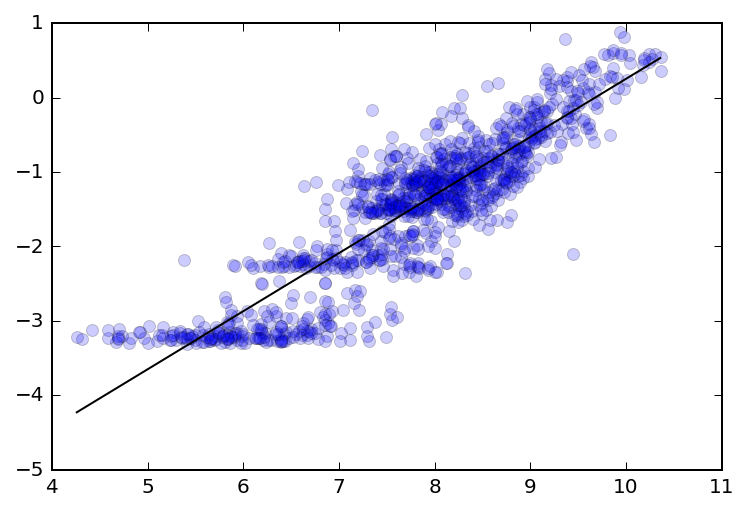

In [398]:
# from scipy.optimize import curve_fit

# def line(x, m, b):
#     return m*x + b

# xarr = np.concatenate((stlr_mass[no_spectra], stlr_mass[yes_spectra]))
# yarr = np.concatenate((dustcorr_sfrs_ns, dustcorr_sfrs_ys))

# coeffs, covar = curve_fit(line, xarr, yarr)
# coeffs
# xx = np.arange(min(xarr), max(xarr), 0.1)

# plt.plot(xarr, yarr, 'bo', alpha=0.2)
# plt.plot(xx, line(xx, *coeffs), 'k')
# plt.show()